In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils import data

## Preparing labels

In [2]:
data = pd.read_csv('stage_2_train_labels.csv').filter(['patientId', 'Target'])
data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [3]:
train_labels, val_labels = train_test_split(data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


## Data Samples

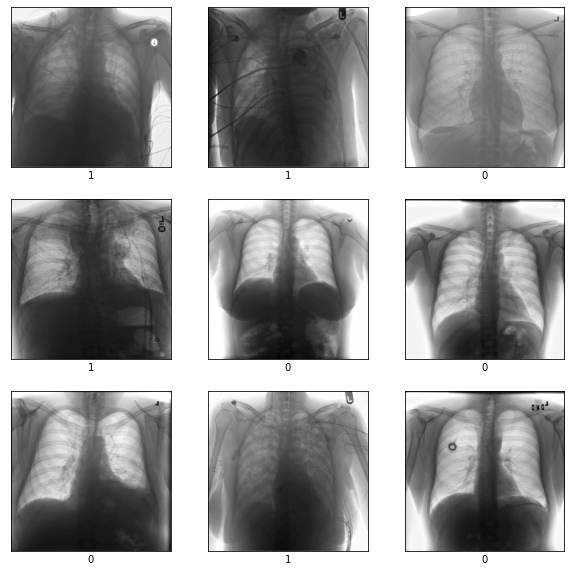

In [6]:
def show(n=9):
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.xticks([])
        plt.yticks([])
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        plt.imshow(img_dcm.pixel_array, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])
show()

## Composing transformations

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()])

## Write a custom dataset 

In [8]:
class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0
        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')
        label = self.labels[index][1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.paths)

## Check the custom dataset

Tensor:tensor([[[0.0431, 0.0431, 0.0431,  ..., 0.0314, 0.0353, 0.0235],
         [0.0431, 0.0431, 0.0431,  ..., 0.0353, 0.0353, 0.0275],
         [0.0431, 0.0431, 0.0431,  ..., 0.0392, 0.0353, 0.0275],
         ...,
         [0.2392, 0.2353, 0.1843,  ..., 0.0235, 0.0235, 0.0157],
         [0.2275, 0.1961, 0.1608,  ..., 0.0235, 0.0235, 0.0157],
         [0.1490, 0.1451, 0.1333,  ..., 0.0196, 0.0196, 0.0118]],

        [[0.0431, 0.0431, 0.0431,  ..., 0.0314, 0.0353, 0.0235],
         [0.0431, 0.0431, 0.0431,  ..., 0.0353, 0.0353, 0.0275],
         [0.0431, 0.0431, 0.0431,  ..., 0.0392, 0.0353, 0.0275],
         ...,
         [0.2392, 0.2353, 0.1843,  ..., 0.0235, 0.0235, 0.0157],
         [0.2275, 0.1961, 0.1608,  ..., 0.0235, 0.0235, 0.0157],
         [0.1490, 0.1451, 0.1333,  ..., 0.0196, 0.0196, 0.0118]],

        [[0.0431, 0.0431, 0.0431,  ..., 0.0314, 0.0353, 0.0235],
         [0.0431, 0.0431, 0.0431,  ..., 0.0353, 0.0353, 0.0275],
         [0.0431, 0.0431, 0.0431,  ..., 0.0392, 0.0

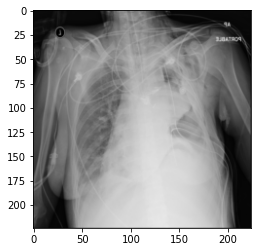

In [9]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
img, label = next(image)
print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

## Train image shape

In [10]:
img.shape

torch.Size([224, 224, 3])

## Load Training and Testing Dataset

In [11]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)

## Check dataloader

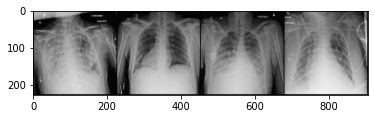

In [12]:
batch = iter(train_loader)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

## Specify device object

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.6) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Load pre-trained AlexNet and fine-tune

In [7]:
model = CNN(2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [8]:
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): AvgPool2d(kernel_size=3, stride=2, padding=0)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classi

In [18]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         AvgPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         AvgPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
           Conv2d-13          [-1, 128, 13, 13]         295,040
             ReLU-14          [-1, 128,

In [15]:
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): AvgPool2d(kernel_size=3, stride=2, padding=0)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classi

## Write a train code and RUN

In [19]:
torch.cuda.empty_cache()
# Train the model
total_step = len(train_loader)
for epoch in range(10):
    # Training
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 2000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    # Validation
    correct = 0
    total = 0  
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

2001it [04:31,  6.32it/s]

Epoch [1/10], Step [2000/3401], Loss: 0.7615


3401it [07:50,  7.23it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:53<00:00,  7.03it/s]


Epoch: 1/10, Val_Acc: 67.64803314208984


2001it [04:29,  7.51it/s]

Epoch [2/10], Step [2000/3401], Loss: 0.6746


3401it [07:43,  7.34it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:52<00:00,  7.26it/s]


Epoch: 2/10, Val_Acc: 67.64803314208984


2001it [04:24,  7.44it/s]

Epoch [3/10], Step [2000/3401], Loss: 0.5752


3401it [07:20,  7.73it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:46<00:00,  8.13it/s]


Epoch: 3/10, Val_Acc: 67.64803314208984


2001it [03:51,  7.79it/s]

Epoch [4/10], Step [2000/3401], Loss: 0.3646


3401it [06:37,  8.56it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:46<00:00,  8.08it/s]


Epoch: 4/10, Val_Acc: 67.64803314208984


2001it [03:56,  7.74it/s]

Epoch [5/10], Step [2000/3401], Loss: 0.6684


3401it [06:50,  8.28it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:49<00:00,  7.61it/s]


Epoch: 5/10, Val_Acc: 67.64803314208984


2001it [04:13,  7.32it/s]

Epoch [6/10], Step [2000/3401], Loss: 0.7669


3401it [07:16,  7.80it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:51<00:00,  7.35it/s]


Epoch: 6/10, Val_Acc: 67.64803314208984


2001it [04:11,  7.55it/s]

Epoch [7/10], Step [2000/3401], Loss: 0.4652


3401it [07:21,  7.70it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:57<00:00,  6.52it/s]


Epoch: 7/10, Val_Acc: 76.81111145019531


2001it [04:39,  7.05it/s]

Epoch [8/10], Step [2000/3401], Loss: 0.5470


3401it [07:52,  7.20it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:50<00:00,  7.46it/s]


Epoch: 8/10, Val_Acc: 75.2232894897461


2001it [04:28,  7.39it/s]

Epoch [9/10], Step [2000/3401], Loss: 0.5477


3401it [07:33,  7.49it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:50<00:00,  7.42it/s]


Epoch: 9/10, Val_Acc: 77.34039306640625


2001it [04:28,  7.31it/s]

Epoch [10/10], Step [2000/3401], Loss: 0.9690


3401it [07:29,  7.57it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 378/378 [00:48<00:00,  7.74it/s]

Epoch: 10/10, Val_Acc: 77.04267120361328


In [21]:
torch.save(model.state_dict(), "cnn.pt")

In [22]:
cnn = AlexNet(2)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn.to(device)
cnn.load_state_dict(torch.load("cnn.pt"))

<All keys matched successfully>

## Test model

In [24]:
cnn.eval()
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.max(cnn(data),1)[1].item()
        preds.append(pred)
        labels.append(label)



100%|███████████████████████████████████████████████████████████████████████████████| 3023/3023 [01:19<00:00, 37.85it/s]


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
acc = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
cm = confusion_matrix(labels, preds)

print(f"Val Accuracy {acc}")
print(f"Val precision {precision}")
print(f"Val Recall {recall}")
print(f"Val F1 {f1}")
print(f"Confusion Matrix {cm}")

Val Accuracy 0.7737347006285147
Val precision 0.7296875
Val Recall 0.4775051124744376
Val F1 0.5772558714462299
Confusion Matrix [[1872  173]
 [ 511  467]]
